In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot, textures_bw_transform
import warnings
warnings.filterwarnings('ignore')
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox 
import json
from datetime import datetime

folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
# prop_list = ['ocd', 'soc', 'bulk.density', 'ph.h2o' ,'coarse']
prop_list = ['ocd', 'soc', 'bulk.density', 'ph.h2o']
transforms_dict = {
    'ocd': 'log1p',
    'soc': 'log1p',
    'bulk.density': None,
    'ph.h2o': None,
    'coarse': 'log1p'
}
prop_list = ['texture1', 'texture2']
transforms_dict = {
    'texture1': None,
    'texture2': None,
}


version = '20250204'

In [2]:
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

In [2]:
import cmcrameri.cm as cm
import matplotlib.colors as mcolors

# Get the colormap
cmap = cm.batlow

# Get RGB tuples at 0.0 and 1.0
low_rgb = cmap(0.0)   # Start of colormap
high_rgb = cmap(1.0)  # End of colormap

# Convert to hex
low_hex = mcolors.to_hex(low_rgb)
high_hex = mcolors.to_hex(high_rgb)

print("Low-end color:", low_hex)
print("High-end color:", high_hex)


Low-end color: #011959
High-end color: #faccfa


# Uncertainty evaluation
### this is only done for random forest

In [8]:
from trees_rf import cast_tree_rf
import matplotlib.pyplot as plt


output_folder = folder_path+'/textures'
os.makedirs(output_folder, exist_ok=True)

prop = 'textures'

# read in material--------------------------------------------------------------
# data
train = pd.read_parquet(f'{output_folder}/data_train_textures_v{version}.pq')
test = pd.read_parquet(f'{output_folder}/data_test_textures_v{version}.pq')
covs1 = read_features(f'{output_folder}/feature_selected_texture1_v{version}.txt')
covs2 = read_features(f'{output_folder}/feature_selected_texture2_v{version}.txt')

mask = train[covs1 + covs2].notna().all(axis=1)
train1 = train[mask].copy()
train2 = train[mask].copy()

mask = test[covs1 + covs2].notna().all(axis=1)
test1 = test[mask].copy()
test2 = test[mask].copy()


# models
model1 = joblib.load(f'{output_folder}/model_rf.texture1_ccc_v{version}.joblib')
model1.n_jobs = 90
model1.fit(train1[covs1], train1['texture1'])
model1 = cast_tree_rf(model1)
# models
model2 = joblib.load(f'{output_folder}/model_rf.texture2_ccc_v{version}.joblib')
model2.n_jobs = 90
model2.fit(train2[covs2], train2['texture2'])
model2 = cast_tree_rf(model2)



tree_predictions1 = model1.predict(test1[covs1])
tree_predictions2 = model2.predict(test2[covs2])

y_pred1 = np.mean(tree_predictions1, axis=0) # get the mean before transformation
y_pred2 = np.mean(tree_predictions2, axis=0) # get the mean before transformation

y_pred_sand, y_pred_silt, y_pred_clay = textures_bw_transform(y_pred1, y_pred2)
tree_predictions_sand, tree_predictions_silt, tree_predictions_clay = textures_bw_transform(tree_predictions1, tree_predictions2)

quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]

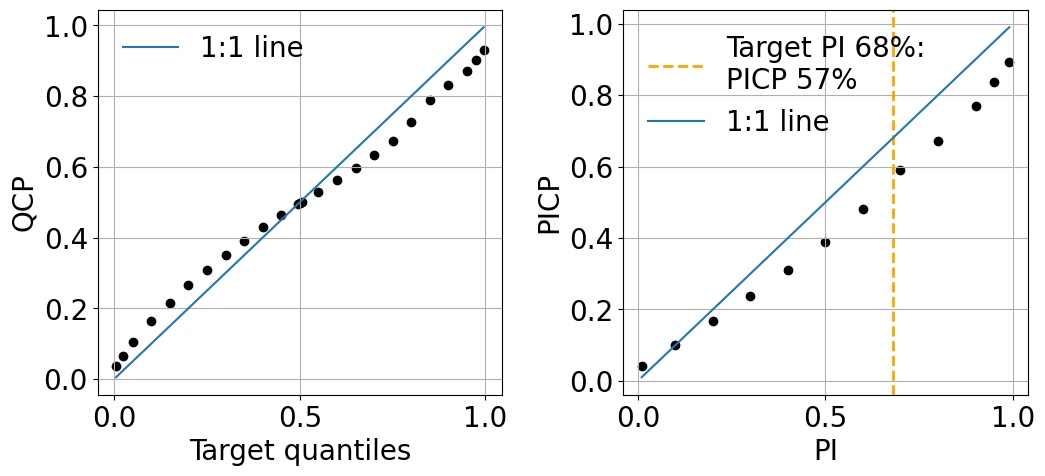

In [18]:

# tree predictions
prop = 'sand'

y_q = np.percentile(tree_predictions_sand, [q * 100 for q in quantiles], axis=0)
qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii], test1[prop], quantiles[ii]))

# calculate piw, picp
pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test1[prop]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

# calculate PICP for target PI (+- 1 std): 68%, P16-P84
target_pi = [0.16, 0.84]
pib = np.percentile(tree_predictions_sand, [q * 100 for q in target_pi], axis=0)
target_picp = calc_picp(pib[0], pib[1], test1[prop])

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[1].axvline(x=0.68, color='orange', linestyle='--', linewidth=2, label=f'Target PI 68%:\nPICP {target_picp*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(wspace=0.3)  
plt.savefig(f'{output_folder}/plot_acuracy.uncertainty_{prop}_v{version}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


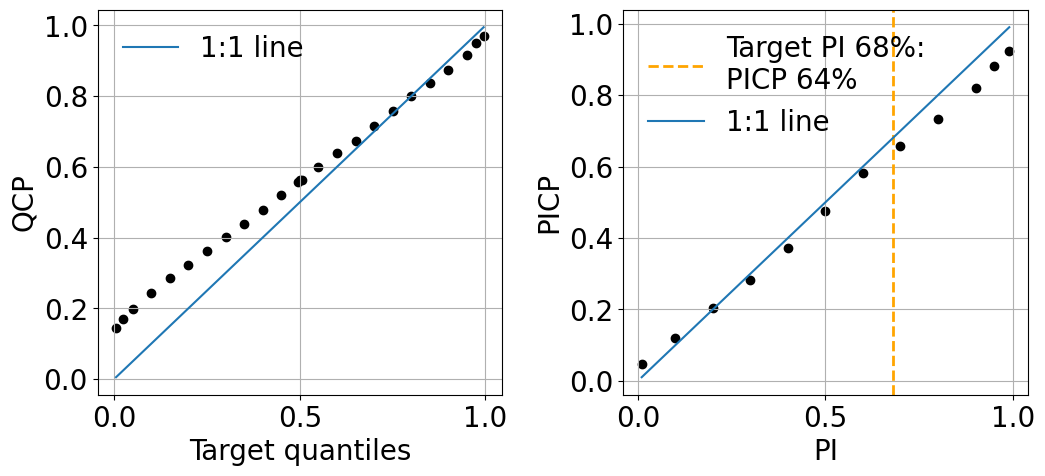

In [19]:

# tree predictions
prop = 'silt'
y_q = np.percentile(tree_predictions_silt, [q * 100 for q in quantiles], axis=0)
qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii], test1[prop], quantiles[ii]))

# calculate piw, picp
pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test1[prop]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

# calculate PICP for target PI (+- 1 std): 68%, P16-P84
target_pi = [0.16, 0.84]
pib = np.percentile(tree_predictions_silt, [q * 100 for q in target_pi], axis=0)
target_picp = calc_picp(pib[0], pib[1], test1[prop])

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[1].axvline(x=0.68, color='orange', linestyle='--', linewidth=2, label=f'Target PI 68%:\nPICP {target_picp*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(wspace=0.3)  
plt.savefig(f'{output_folder}/plot_acuracy.uncertainty_{prop}_v{version}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


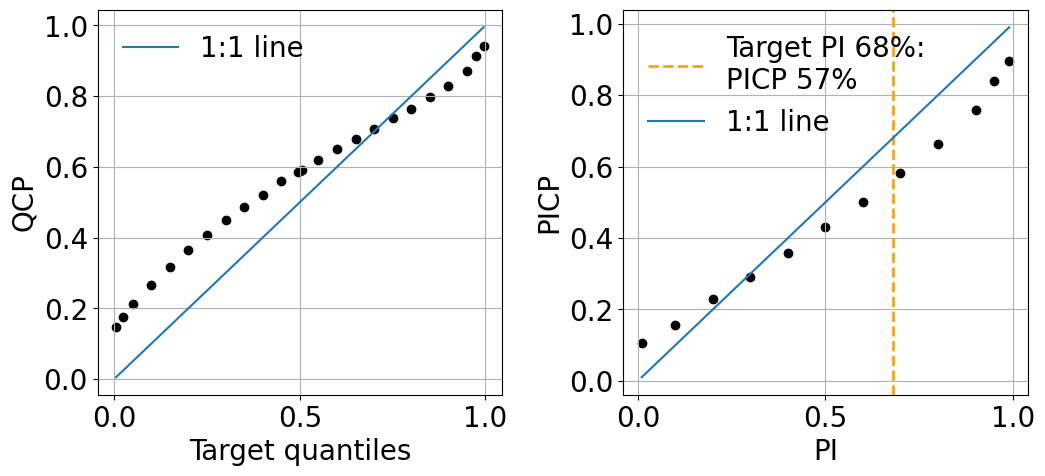

In [24]:

# tree predictions
prop = 'clay'

y_q = np.percentile(tree_predictions_clay, [q * 100 for q in quantiles], axis=0)
qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii], test1[prop], quantiles[ii]))

# calculate piw, picp
pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test1[prop]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

# calculate PICP for target PI (+- 1 std): 68%, P16-P84
target_pi = [0.16, 0.84]
pib = np.percentile(tree_predictions_clay, [q * 100 for q in target_pi], axis=0)
target_picp = calc_picp(pib[0], pib[1], test1[prop])

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[1].axvline(x=0.68, color='orange', linestyle='--', linewidth=2, label=f'Target PI 68%:\nPICP {target_picp*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(wspace=0.3)  
plt.savefig(f'{output_folder}/plot_acuracy.uncertainty_{prop}_v{version}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
